In [3]:
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
import numpy as np

import warnings
warnings.filterwarnings(action='once')

sns.set_style("darkgrid")
sns.set(font_scale=1.5)
%matplotlib inline

In [4]:
def query_data(query, parms=None):
    """Shared query wrapper"""
    engine = create_engine('sqlite:///./../../data/processed/airlines.db')
    with engine.connect() as conn:
        data = pd.read_sql(sql=query, con=conn, params=parms)
    return data

def round_to_last_quarter_of_hour(ts):
    """Revert a timestamp to the last quarter hour, for use with pd.apply()"""
    return datetime(ts.year, ts.month, ts.day, ts.hour,15*(ts.minute // 15))

def back_one_hour(ts):
    """Return a timestamp a set number of hours in past"""
    return ts - timedelta(hours=1)

In [5]:
def query_departures(airport='ATL', start_date=None, end_date=None):
    """Query departure data from flights for selected origin airport and year"""
    if start_date is None:
        start_date = date(2017, 1, 1)
    if end_date is None:
        end_date = date(2017, 12, 31)
    
    query = """
    SELECT
        f.departure_was_delayed_15,
        f.year,
        f.month,
        f.day_of_week,
        f.origin,
        f.dest,
        f.departure_time_scheduled as scheduled_departure_time,
        f.distance as flight_distance,
        f.elapsed_time_scheduled as scheduled_travel_time
    FROM
        flights AS f
    WHERE
        f.Origin = :airport
    AND
        f.flight_date
    BETWEEN :start_date
        AND :end_date
    """
    data = query_data(query, parms={'airport': airport, 'start_date':start_date, 'end_date':end_date})
    # Build datetime elements for merging
    data['scheduled_departure_time'] = data['scheduled_departure_time'].apply(pd.to_datetime)
    data['hour_of_day'] = data['scheduled_departure_time'].dt.hour
    data['departure_block'] = data['scheduled_departure_time'].apply(round_to_last_quarter_of_hour)
    data['departure_block_minus_one_hour'] = data['departure_block'].apply(back_one_hour)
    data['departure_block_minus_two_hours'] = data['departure_block_minus_one_hour'].apply(back_one_hour)
    data['departure_block_minus_three_hours'] = data['departure_block_minus_two_hours'].apply(back_one_hour)
    return data

departures = query_departures()
departures.head()

,departure_was_delayed_15,year,month,day_of_week,origin,dest,scheduled_departure_time,flight_distance,scheduled_travel_time,hour_of_day,departure_block,departure_block_minus_one_hour,departure_block_minus_two_hours,departure_block_minus_three_hours
0,0,2017,9,2,ATL,BOS,2017-09-26 09:30:00,946,165,9,2017-09-26 09:30:00,2017-09-26 08:30:00,2017-09-26 07:30:00,2017-09-26 06:30:00
1,0,2017,9,2,ATL,BOS,2017-09-26 12:47:00,946,165,12,2017-09-26 12:45:00,2017-09-26 11:45:00,2017-09-26 10:45:00,2017-09-26 09:45:00
2,0,2017,9,2,ATL,BOS,2017-09-26 17:25:00,946,171,17,2017-09-26 17:15:00,2017-09-26 16:15:00,2017-09-26 15:15:00,2017-09-26 14:15:00
3,0,2017,9,2,ATL,BOS,2017-09-26 19:56:00,946,169,19,2017-09-26 19:45:00,2017-09-26 18:45:00,2017-09-26 17:45:00,2017-09-26 16:45:00
4,0,2017,9,2,ATL,BOS,2017-09-26 07:00:00,946,165,7,2017-09-26 07:00:00,2017-09-26 06:00:00,2017-09-26 05:00:00,2017-09-26 04:00:00


In [6]:
departures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363955 entries, 0 to 363954
Data columns (total 14 columns):
departure_was_delayed_15             363955 non-null int64
year                                 363955 non-null int64
month                                363955 non-null int64
day_of_week                          363955 non-null int64
origin                               363955 non-null object
dest                                 363955 non-null object
scheduled_departure_time             363955 non-null datetime64[ns]
flight_distance                      363955 non-null int64
scheduled_travel_time                363955 non-null int64
hour_of_day                          363955 non-null int64
departure_block                      363955 non-null datetime64[ns]
departure_block_minus_one_hour       363955 non-null datetime64[ns]
departure_block_minus_two_hours      363955 non-null datetime64[ns]
departure_block_minus_three_hours    363955 non-null datetime64[ns]
dtypes: datetime

In [7]:
def query_weather(station_id='WBAN:13874', start_date=None, end_date=None):
    """Query weather data based on station_id"""
    if start_date is None:
        start_date = date(2017, 1, 1)
    if end_date is None:
        end_date = date(2017, 12, 31)
    
    query = """
    SELECT
        w.station,
        w.station_name,
        w.date,
        w.hourly_visibility as visibility,
        w.hourly_dry_bulb_temp_f as temperature_f,
        w.hourly_precipitation as precipitation,
        w.hourly_wind_speed as average_windspeed,
        w.hourly_wind_gust_speed as maximum_gust_speed,
        w.hourly_station_pressure as station_pressure
    FROM
        weather AS w
    WHERE
        w.station = :station_id
    AND
        w.date
    BETWEEN :start_date
        AND :end_date
    """
    data = query_data(query, parms={'station_id':station_id, 'start_date':start_date, 'end_date':end_date})
    
    # Handle prep for timestamp features
    data['date'] = data['date'].apply(pd.to_datetime)
    data.set_index(['date'], inplace=True)
    data = data.resample('15min').ffill()
    return data

weather = query_weather()
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34941 entries, 2017-01-01 00:45:00 to 2017-12-30 23:45:00
Freq: 15T
Data columns (total 8 columns):
station               34940 non-null object
station_name          34940 non-null object
visibility            34940 non-null float64
temperature_f         34940 non-null float64
precipitation         34940 non-null float64
average_windspeed     34940 non-null float64
maximum_gust_speed    34940 non-null float64
station_pressure      34940 non-null float64
dtypes: float64(6), object(2)
memory usage: 2.4+ MB


In [8]:
weather.head()

,station,station_name,visibility,temperature_f,precipitation,average_windspeed,maximum_gust_speed,station_pressure
date,,,,,,,,
2017-01-01 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:00:00,WBAN:13874,ATLANTA HARTSFIELD INTERNATIONAL AIRPORT GA US,5.0,42.0,0.05,11.0,17.0,28.98
2017-01-01 01:15:00,WBAN:13874,ATLANTA HARTSFIELD INTERNATIONAL AIRPORT GA US,5.0,43.0,0.05,15.0,0.0,28.96
2017-01-01 01:30:00,WBAN:13874,ATLANTA HARTSFIELD INTERNATIONAL AIRPORT GA US,5.0,43.0,0.05,22.0,26.0,28.92
2017-01-01 01:45:00,WBAN:13874,ATLANTA HARTSFIELD INTERNATIONAL AIRPORT GA US,5.0,43.0,0.00,9.0,0.0,28.95


In [9]:
def prepare_features_for_analysis(d, w):
    #data = d.merge(right=w, left_on='departure_block', right_index=True, suffixes=("", ""), how='left')
    #data = data.merge(right=w, left_on='departure_block_minus_one_hour', right_index=True, suffixes=("", "_minus_one"), how='left')
    #data = data.merge(right=w, left_on='departure_block_minus_two_hours', right_index=True, suffixes=("", "_minus_two"), how='left')
    data = d.merge(right=w, left_on='departure_block_minus_three_hours', right_index=True, suffixes=("", "_minus_three"), how='left')
    
    return  data.select_dtypes(include=[np.number])

features = prepare_features_for_analysis(departures, weather)

In [10]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363955 entries, 0 to 363954
Data columns (total 13 columns):
departure_was_delayed_15    363955 non-null int64
year                        363955 non-null int64
month                       363955 non-null int64
day_of_week                 363955 non-null int64
flight_distance             363955 non-null int64
scheduled_travel_time       363955 non-null int64
hour_of_day                 363955 non-null int64
visibility                  363955 non-null float64
temperature_f               363955 non-null float64
precipitation               363955 non-null float64
average_windspeed           363955 non-null float64
maximum_gust_speed          363955 non-null float64
station_pressure            363955 non-null float64
dtypes: float64(6), int64(7)
memory usage: 36.1 MB


# To what extent are there correlations in the existing features?

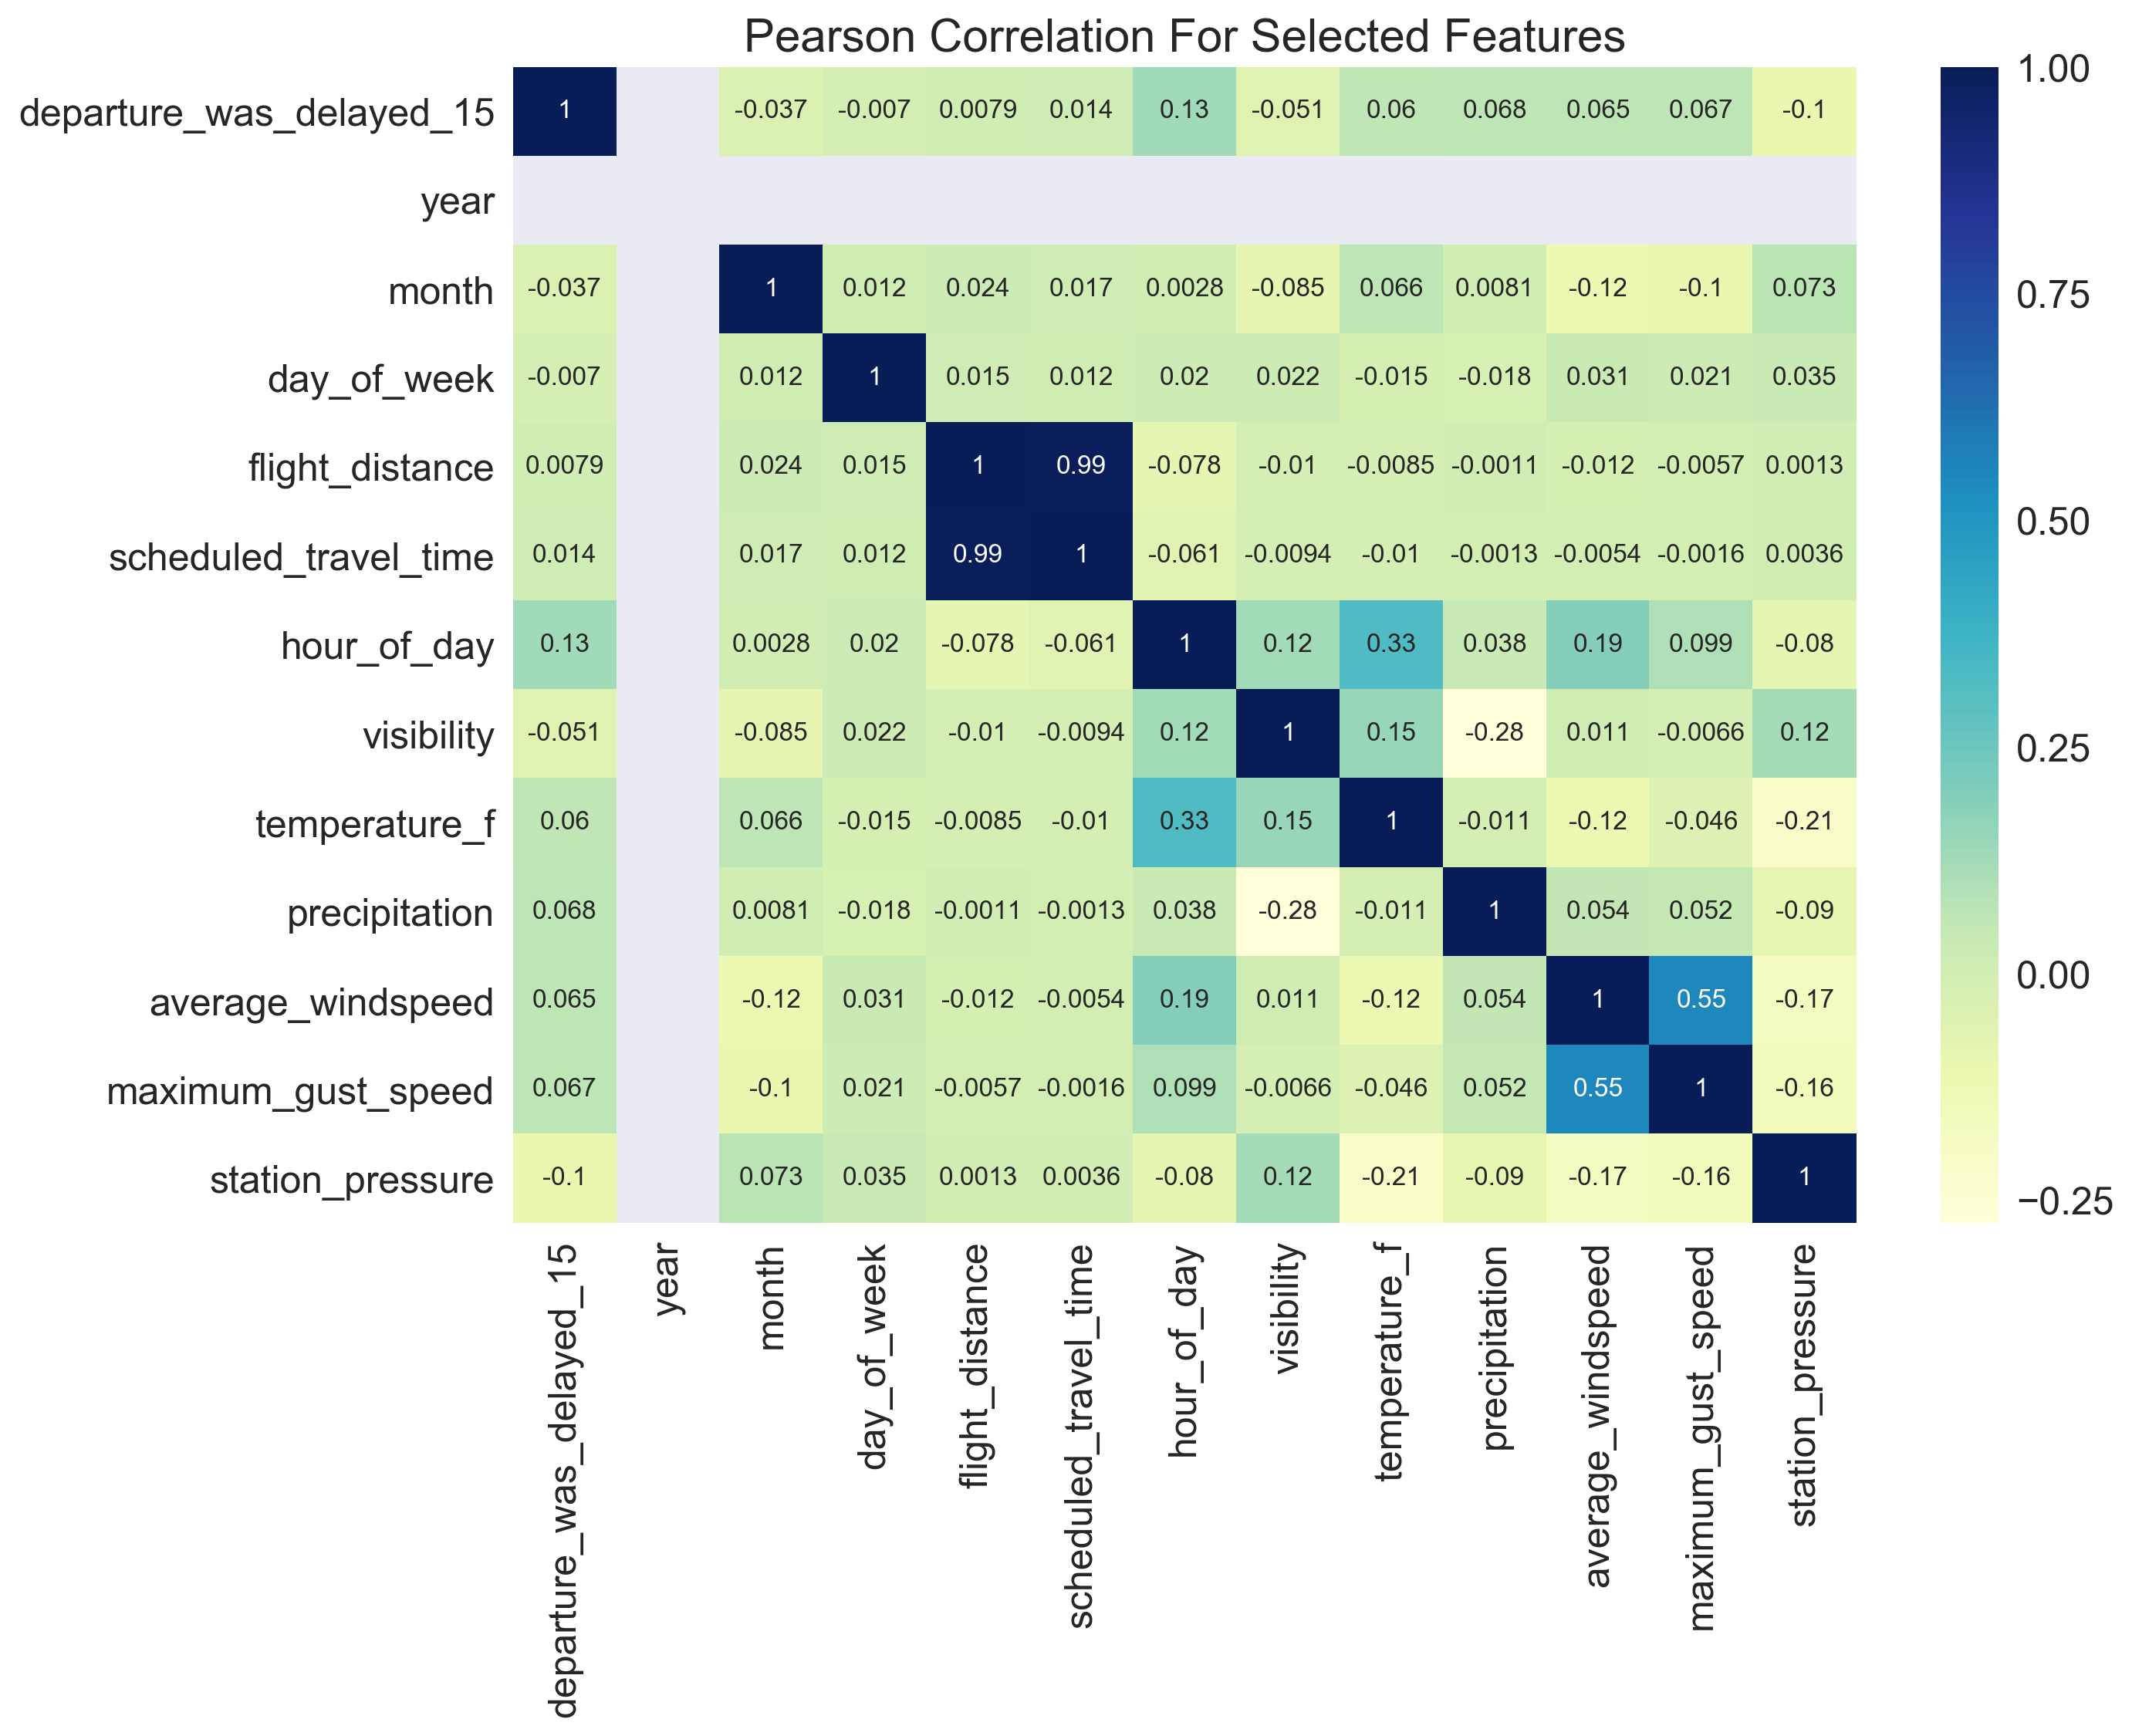

In [11]:
def plot_correlation_heatmap(correlation_matrix, save_image=False):
    fig, ax = plt.subplots(figsize=(11.7, 8.27), dpi=240)

    plt.title("Pearson Correlation For Selected Features")
    sns.heatmap(correlation_matrix, ax=ax, annot=True,  cmap="YlGnBu")
    if save_image:
        plt.savefig("../../reports/figures/initial-feature-set-correlation.png", bbox_inches='tight')
    plt.show()
    
plot_correlation_heatmap(features.corr(), save_image=True)

There High levels of correlation between elapsed time and flight distance (i.e. a flight that travels further will be in the air longer.)  Also, for this iteration, year is constant and should be dropped from feature space.

In [12]:
y = features['departure_was_delayed_15']
X = features.drop(['departure_was_delayed_15', 'flight_distance', 'year'], axis=1)

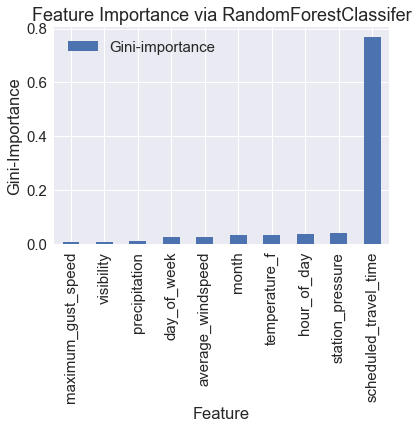

In [14]:
## generate a plot of gini importances with and without balance classes, showing that even that one small change can have an impact on what is important

from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd

def estimate_feature_importances(X, y, feature_names, class_weight=None):
    forest = ExtraTreesClassifier(n_estimators=250, random_state=0, class_weight=class_weight)
    forest.fit(X, y)
    
    features = {}
    for feature, importance in zip(feature_names, forest.feature_importances_):
        features[feature] = importance #add the name/value pair 

    importances = pd.DataFrame.from_dict(features, orient='index').rename(columns={0: 'Gini-importance'})
    
    importances.sort_values(by='Gini-importance').plot(kind='bar')
    plt.xlabel('Feature')
    plt.ylabel('Gini-Importance')
    plt.title('Feature Importance via RandomForestClassifer')
    plt.show()
    return importances

importances = estimate_feature_importances(X=X, y=y, feature_names=X.columns)

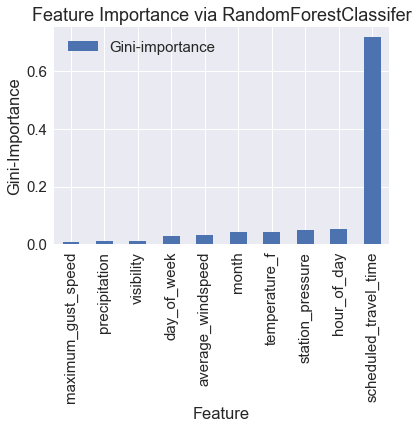

In [15]:
importances = estimate_feature_importances(X=X, y=y, feature_names=X.columns, class_weight='balanced')

In [16]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

def evaluate_pipeline(X, y, param_grid, pipeline, scoring='accuracy', random_state=12):
    """ Conduct a GridSearchCV with supplied pipeline and parameters, use reserved data for output metrics"""
    
    # Reserve a portion of the data, to reduce overfitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)
    
    # Initiate GridSearchCV, with 5-fold cross validtation schema, using selected scoring method
    grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring=scoring)
   
    # Fit the Grid to the training data
    grid.fit(X=X_train, y=y_train)
    
    # Inspect the output of the gridsearch
    print("   Scoring Methodology:", scoring)
    print("            Best Score:", grid.best_score_)
    print("        Best Estimator:")
    print(grid.best_estimator_)
    
    # Use the fitted grid to predict on the test data
    y_pred = grid.predict(X_test)
    print("----------------- Test Set Results -----------------")
    print("              Accuracy:", accuracy_score(y_pred=y_pred, y_true=y_test))
    print(" Classification Report:\n", classification_report(y_pred=y_pred, y_true=y_test))
    
    # Return the fitted grid for use, inspection, and storage
    return grid

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

random_state = 12

pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('select', SelectKBest()),
    ('approximate', None),
    ('classify', None)
])

In [18]:
from sklearn.dummy import DummyClassifier

dummy_paramters = [
    {
        'select__k': ['all'],
        'classify': [DummyClassifier()],
        'classify__strategy': ['stratified'],
        'classify__random_state': [random_state]
    }
]

# Dummy Classifier provides a point of comparison for other classifiers, in this a rand
grid = evaluate_pipeline(X, y, dummy_paramters, pipeline, scoring='precision', random_state=random_state)

   Scoring Methodology: precision
            Best Score: 0.17673674554687832
        Best Estimator:
Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select', SelectKBest(k='all', score_func=<function f_classif at 0x10d9d31e0>)), ('approximate', None), ('classify', DummyClassifier(constant=None, random_state=12, strategy='stratified'))])
----------------- Test Set Results -----------------
              Accuracy: 0.7086073967994938
 Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.82      0.82     98771
          1       0.18      0.18      0.18     21335

avg / total       0.71      0.71      0.71    120106



In [19]:
from sklearn.neighbors import KNeighborsClassifier   

knn_parameters = [
    {
        'select__k': ['all'],
        'classify': [KNeighborsClassifier()],
        'classify__weights': ['uniform'],
        'classify__algorithm': ['auto'],
        'classify__n_neighbors': [3],
        'classify__n_jobs': [4],
    }
]

# Did not successfully run full dataset on local machine, due to resource limitations
grid = evaluate_pipeline(X, y, knn_parameters, pipeline, scoring='precision', random_state=random_state)

   Scoring Methodology: precision
            Best Score: 0.39821726698615706
        Best Estimator:
Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select', SelectKBest(k='all', score_func=<function f_classif at 0x10d9d31e0>)), ('approximate', None), ('classify', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=3, p=2,
           weights='uniform'))])
----------------- Test Set Results -----------------
              Accuracy: 0.7994604765790219
 Classification Report:
              precision    recall  f1-score   support

          0       0.85      0.92      0.88     98771
          1       0.40      0.25      0.31     21335

avg / total       0.77      0.80      0.78    120106



In [ ]:
from sklearn.svm import SVC

svc_parameters = [
    {
        'select__k': [10, 'all'],
        'classify': [SVC()],
        'classify__class_weight': ['balanced'],
        'classify__kernel': ['rbf'],
        'classify__gamma': ['auto'],
        'classify__C': [1.0],
        'classify__random_state': [random_state]        
    }
]

# Stopped due to excessive runtime
#grid = evaluate_pipeline(X, y, svc_parameters, pipeline, scoring='precision', random_state=random_state)

In [21]:
from sklearn.ensemble import RandomForestClassifier

random_forest_parameters = [
    {
        'select__k': [2,4,8,'all'],
        'classify': [RandomForestClassifier()],
        'classify__class_weight': ['balanced', 'balanced_subsample', None],
        'classify__criterion': ['gini', 'entropy'],
        'classify__max_features': ['auto', 'log2'],
        'classify__max_depth': [2, 10, 15, None],
        'classify__n_jobs': [4],
        'classify__random_state': [random_state]        
    }
]

grid = evaluate_pipeline(X, y, random_forest_parameters, pipeline, scoring='precision', random_state=random_state)

/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcbeidel/anaconda3/lib/python3.6/

/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcbeidel/anaconda3/lib/python3.6/

/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcbeidel/anaconda3/lib/python3.6/

   Scoring Methodology: precision
            Best Score: 0.672997681127606
        Best Estimator:
Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select', SelectKBest(k=8, score_func=<function f_classif at 0x10d9d31e0>)), ('approximate', None), ('classify', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_feat...stimators=10, n_jobs=4,
            oob_score=False, random_state=12, verbose=0, warm_start=False))])
----------------- Test Set Results -----------------
              Accuracy: 0.828901137328693
 Classification Report:
              precision    recall  f1-score   support

          0       0.83      0.99      0.91     98771
          1       0.69      0.07      0.12     21335

avg / total       0.81      0.83      0.77    120106



In [23]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier

kernel_approximation_parameters = [
    {
        'approximate': [RBFSampler()],
        'approximate__gamma': [0.1, 1, 10],
        'approximate__n_components': [100],
        'classify': [SGDClassifier()],
        'classify__max_iter': [5],
        'classify__class_weight': ['balanced'],
        'classify__n_jobs': [4],
        'classify__random_state': [random_state]        
    }
]

grid = evaluate_pipeline(X, y, kernel_approximation_parameters, pipeline, scoring='precision', random_state=random_state)

   Scoring Methodology: precision
            Best Score: 0.2636392085029685
        Best Estimator:
Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select', SelectKBest(k=10, score_func=<function f_classif at 0x10d9d31e0>)), ('approximate', RBFSampler(gamma=0.1, n_components=100, random_state=None)), ('classify', SGDClassifier(alpha=0.0001, average=False, class_weight...ty='l2', power_t=0.5, random_state=12, shuffle=True,
       tol=None, verbose=0, warm_start=False))])
----------------- Test Set Results -----------------
              Accuracy: 0.5871979751219756
 Classification Report:
              precision    recall  f1-score   support

          0       0.88      0.57      0.70     98771
          1       0.25      0.65      0.36     21335

avg / total       0.77      0.59      0.64    120106

